In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation

In [8]:
pop = 10000 # 人群数
touch = 5  # 日均接触人群数
init_infec = 10 # 初始患者
beta = 0.3  # 感染几率

In [3]:
loc = np.random.rand(pop,2).round(3)*100

# 计算距离矩阵
x, y = loc[:,0], loc[:,1]
x = np.tile(x, (pop,1))
y = np.tile(y, (pop,1))
d_mat = np.sqrt((x - x.T)**2 + ( y- y.T)**2)
# 生成临界点字典
dis_dict = {}
con_mat_ = np.zeros([pop, 19], dtype=int)

for i in range(pop):
    val = np.argsort(d_mat[:,i])[1:20]
    dis_dict[i] = val
    con_mat_[i, :] = val

In [9]:
# init
con_mat = con_mat_[:, :touch]
df = pd.DataFrame(loc, columns=['x','y'])
idx = np.random.choice(pop,init_infec, replace=False)
is_infec = np.zeros(pop)
is_infec[idx] = 1

df['is_infec'] = is_infec
df['infec_days'] = is_infec

In [10]:
# 无治疗感染几率抽样
# df.plot.scatter('x', 'y', figsize=(8,8), color='b')
xt, yt = [], []

t = 100
count = []

for i in range(t):
    infeced = df[df['is_infec'] == 1].index.tolist()
    infec = np.random.choice(2, [len(infeced), touch], p=[1-beta, beta])
    infec_id = list(set((con_mat[infeced,:]*infec).reshape(len(infeced)*(touch)).tolist()))

    new_infec = list(set(infec_id).difference(set(infeced)))
    df['is_infec'].loc[new_infec] = 1
    df['infec_days'].loc[new_infec] = 1
    
    x, y = df[df['is_infec'] == 1].x.values, df[df['is_infec'] == 1].y.values
    xt.append(x)
    yt.append(y)
    count.append(df.is_infec.sum())
#     df[df['is_infec'] == 1].plot.scatter('x', 'y', figsize=(8,8), color='r')

MovieWriter imagemagick unavailable.


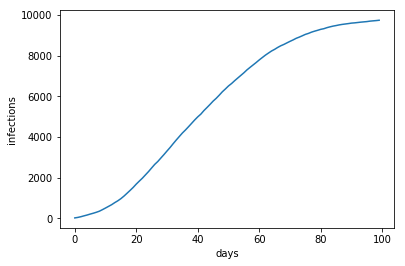

C:\Users\ray-z\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


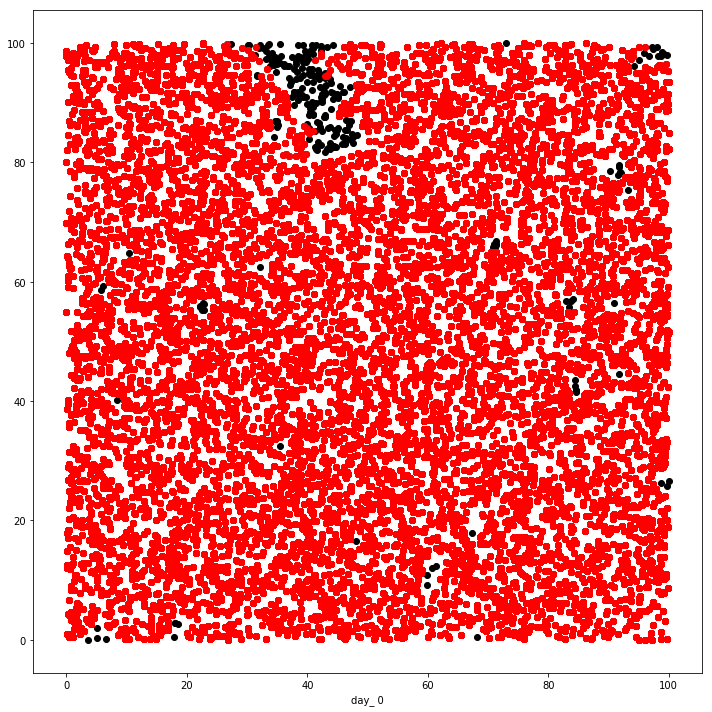

In [11]:
fig, ax = plt.subplots()
ax.set_xlabel('days')
ax.set_ylabel('infections')
plt.plot(range(t), count)

def update(i):
    
    label = 'day_ {0}'.format(i)
    ax.scatter(xt[i], yt[i], color='r')
    ax.set_xlabel(label)
    
    return ax

fig, ax = plt.subplots(figsize=(10,10))
fig.set_tight_layout(True)
x, y = df.x.values, df.y.values
ax.scatter(x, y, color='black')
anim = FuncAnimation(fig, update, frames=np.arange(0, t), interval=100)
anim.save('propa.gif', dpi=80, writer='imagemagick')

In [12]:
count5 = count

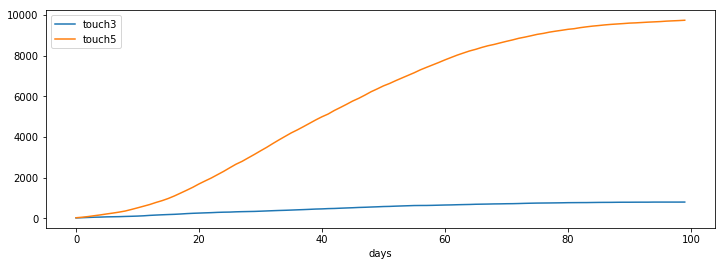

In [13]:
stat_df1 = pd.DataFrame([count3, count5]).T
stat_df1.columns=['touch3', 'touch5']
stat_df1.index.name = 'days'
stat_df1.plot(figsize=(12,4))

In [74]:
# init
bed = 1000 # 床位
cure_days = 10 # 治愈时间
discover = 10 # 发症时间

df = pd.DataFrame(loc, columns=['x', 'y'])
idx = np.random.choice(pop,init_infec, replace=False)
is_infec = np.zeros(pop)
is_infec[idx] = 1

df['is_infec'] = is_infec
df['infec_days'] = is_infec
df['in_hosp'] = np.zeros(pop)
df['cure_days'] = np.zeros(pop)
df['injured'] = np.zeros(pop)

df['infec_days'][df['is_infec'] == 1] += 1

In [75]:
xt, yt = [], []
inj_x, inj_y = [], []

t = 200
count = []
used_bed = []
injured = []


for i in range(t):
    # 更新状态
    df['infec_days'][(df['is_infec'] == 1) & (df['in_hosp'] == 0)] += 1
    df['cure_days'][(df['in_hosp'] == 1)] -= 1
    
    # 出院，清空床位
    out_id = df[(df['in_hosp'] == 1) & (df['cure_days'] == 0)].index 
    df.loc[out_id, ['is_infec', 'infec_days', 'in_hosp']] = 0
    df.loc[out_id, ['injured']] = 1
#     print('out_id', out_id)
    
    # 传染, 假定治愈后不再被传染
    infeced = df[(df['is_infec'] == 1) & (df['in_hosp'] == 0)].index.tolist()
    infec = np.random.choice(2, [len(infeced), touch], p=[1-beta, beta])
    infec_id = list(set((con_mat[infeced,:]*infec).reshape(len(infeced)*(touch)).tolist()))   # 传染对象

    in_hosp_id = df[(df['in_hosp'] == 1)].index.tolist()
    injured_id = df[(df['injured'] == 1)].index.tolist()
    
    new_infec = list(set(infec_id).difference(set(infeced)))
    new_infec = list(set(new_infec).difference(set(in_hosp_id)))    # 住院不被传染
    new_infec = list(set(new_infec).difference(set(injured_id)))    # 治愈不被传染
     
    df['is_infec'].loc[new_infec] = 1
    df['infec_days'].loc[new_infec] = 1
    
    #  新入院
    occupied_bed = df[(df['in_hosp'] == 1)].shape[0]
    empty_bed = bed - occupied_bed
    
    qualified_id = df[(df['is_infec'] == 1) & (df['infec_days'] >= 10) & (df['in_hosp'] == 0)].index.tolist()
#     print(qualified_id)
    if empty_bed == 0:
        continue
    elif len(qualified_id) <= empty_bed:
        df['in_hosp'].loc[qualified_id] = 1
        df['cure_days'].loc[qualified_id] = cure_days
#         print(qualified_id)

    else:  # 病床不够，随机抽取入院
        qualified_id_ = np.random.choice(qualified_id, empty_bed, replace=False)
        df['in_hosp'].loc[qualified_id_] = 1
        df['cure_days'].loc[qualified_id_] = cure_days
        
    x, y = df[df['is_infec'] == 1].x.values, df[df['is_infec'] == 1].y.values
    xt.append(x)
    yt.append(y)
    
    ix, iy = df[df['injured'] == 1].x.values, df[df['injured'] == 1].y.values
    inj_x.append(ix) 
    inj_y.append(iy) 
    
    count.append(df.is_infec.sum())
    used_bed.append(df[(df['in_hosp'] == 1)].shape[0])
    injured.append(df[(df['injured'] == 1)].shape[0])
    
#     print('day',i, 'occupied_bed', df[(df['in_hosp'] == 1)].shape[0])
#     print('infecs', df['is_infec'][df['is_infec'] == 1].sum())

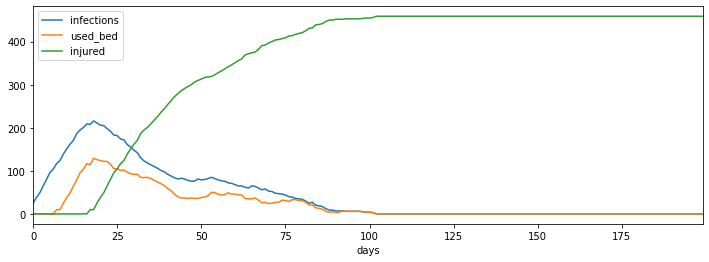

In [76]:
stat_df = pd.DataFrame([count, used_bed, injured]).T
stat_df.columns=['infections', 'used_bed', 'injured']
stat_df.index.name = 'days'
stat_df.plot(figsize=(12,4))

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


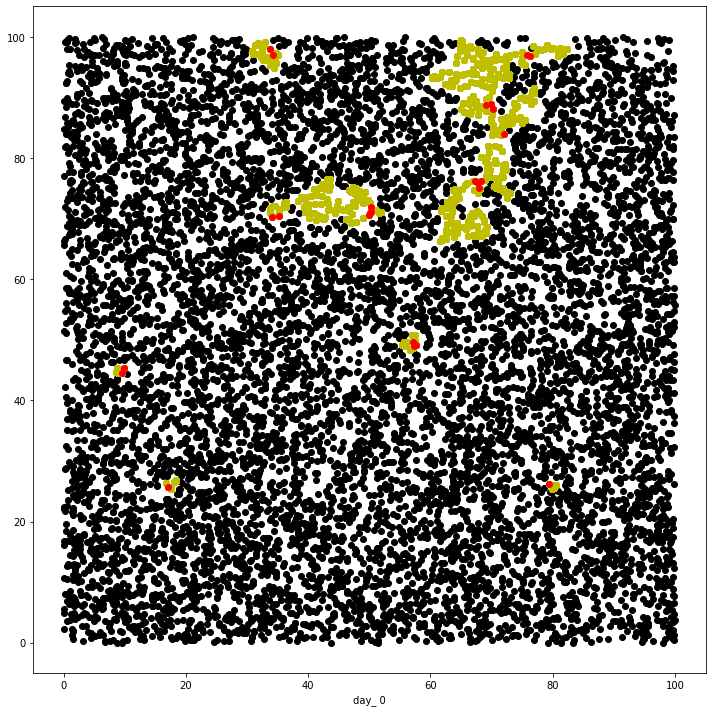

In [77]:
def update(i):
    
    label = 'day_ {0}'.format(i)
    ax.scatter(xt[i], yt[i], color='r')
    ax.scatter(inj_x[i], inj_y[i], color='y')
    ax.set_xlabel(label)
    
    return ax

fig, ax = plt.subplots(figsize=(10,10))
fig.set_tight_layout(True)
x, y = df.x.values, df.y.values
ax.scatter(x, y, color='black')
anim = FuncAnimation(fig, update, frames=np.arange(0, t), interval=200)
anim.save('cured.gif', dpi=80, writer='imagemagick')

In [ ]:
bed = 10 # 床位
cure_days = 10 # 治愈时间

In [ ]:
def update(i):
    
    label = 'day_ {0}'.format(i)
    ax.scatter(xt[i], yt[i], color='r')
    ax.set_xlabel(label)
    
    return ax

fig, ax = plt.subplots(figsize=(10,10))
fig.set_tight_layout(True)
x, y = df.x.values, df.y.values
ax.scatter(x, y, color='black')
anim = FuncAnimation(fig, update, frames=np.arange(0, t), interval=200)
anim.save('line.gif', dpi=80, writer='imagemagick')

In [ ]:
df.plot.scatter('x', 'y', figsize=(8,8), color='b')
df[df['is_infec'] == 1].plot.scatter('x', 'y', figsize=(8,8), color='r')

In [ ]:
x, y = df.x.values, df.y.values

In [ ]:
def update(i):
    label = 'timestep {0}'.format(i)
    ax.scatter(x[:i], y[:i], color='b')
    ax.set_xlabel(label)
    
    return line, ax

fig, ax = plt.subplots()
fig.set_tight_layout(True)

ax.scatter(x, y, color='r')
anim = FuncAnimation(fig, update, frames=np.arange(0, 5), interval=2000)
anim.save('line.gif', dpi=80, writer='imagemagick')

In [ ]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
fig.set_tight_layout(True)

# 询问图形在屏幕上的大小和DPI（每英寸点数）
# 注意当把图形保存为文件时，需要为此单独再提供一个DPI
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

# 绘制一个保持不变（不会被重新绘制）的散点图以及初始直线
x = np.arange(0, 20, 0.1)
ax.scatter(x, x + np.random.normal(0, 3.0, len(x)))
line, = ax.plot(x, x - 5, 'r-', linewidth=2)

def update(i):
    label = 'timestep {0}'.format(i)
    print(label)
# 更新直线和轴（用一个新X轴标签）
    # 以元组形式返回这一帧需要重新绘制的物体
    line.set_ydata(x - 5 + i)
    ax.set_xlabel(label)
    return line, ax

if __name__ == '__main__':
    # 会为每一帧调用Update函数
    # 这里FunAnimation设置一个10帧动画，每帧间隔200ms
    anim = FuncAnimation(fig, update, frames=np.arange(0, 10), interval=200)
    anim.save('line.gif', dpi=80, writer='imagemagick')
#     else:
#         # Plt.show()会一直循环动画
#         plt.show()